 density low <=> sigma big => entropy big => perplexity big
 
 https://github.com/maestrojeong/t-SNE
 

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
%matplotlib inline

In [3]:
mnist = input_data.read_data_sets('/tmp/MNIST_data', one_hot=True)

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


In [33]:
val = {}
ndata = 1000
val['image'] = mnist.validation.images[:ndata]
val['label'] = mnist.validation.labels[:ndata]

In [34]:
sq_dist= np.zeros([ndata, ndata])
for i in range(ndata):
    for j in range(ndata):
        sq_dist[i][j] = np.sum(np.square(val['image'][i]-val['image'][j]))

In [35]:
def normalize(array):
    '''
    normalize for 1D array
    '''
    return array/np.sum(array)

def get_entropy(array):
    '''
    Calculate entropy for 1D array
    '''
    if np.sum(array) !=1:
        array = normalize(array)
        
    sum_ = 0
    length = len(array)
    for i in range(length):
        if array[i]!=0:
            sum_+=array[i]*np.log2(array[i])
    return -sum_

def get_prob(sigma_1d):
    '''
    prob[i][j] = p_{j|i}
    '''
    prob = np.zeros([ndata, ndata])
    for i in range(ndata):
        for j in range(ndata):
            prob[i][j] = np.exp(-sq_dist[i][j]/2/sigma_1d[i]/sigma_1d[i])
    
    #diagonal should be 0
    for i in range(ndata):
        prob[i][i] = 0 
    
    for i in range(ndata):
        prob[i] = normalize(prob[i])
    
    return prob

def get_prob_1d(row, sigma):
    '''
    prob[i][j] = p_{j|i}
    return prob[i]
    '''
    prob = np.zeros(ndata)
    for j in range(ndata):
        prob[j] = np.exp(-sq_dist[row][j]/2/sigma/sigma)
    
    #diagonal should be 0
    prob[row] = 0 
    
    return normalize(prob)


def get_perp(entropy):
    return np.power(2, entropy)

def get_shape(tensor):
    return tensor.get_shape().as_list()

def t_sne(y):
    '''
    Arg :
        y - 2D tensor [ndata, nmap]
    '''
    batch, nmap = get_shape(y)
    y_tr = tf.transpose(y)
    y_mapped = []
    for i in range(nmap):
        y_mapped.append(tf.transpose([y_tr[i]])-y_tr[i])
    y_square = 0
    for i in range(nmap):
        y_square+= tf.square(y_mapped[i])
    y_add = y_square+1
    y_div = tf.div(1., y_add)
    y_mask = y_div*(1-tf.eye(batch))
    y_sum = tf.reduce_sum(y_mask)
    y_normalize = y_mask/y_sum
    cost = -tf.reduce_mean(joint_prob*tf.log(clip(y_normalize)))
    return cost

def clip(x, vmax = 1-1e-10, vmin = 1e-10):
    return tf.clip_by_value(x, clip_value_max=vmax, clip_value_min=vmin)

In [37]:
max_try = 2000
boundary = 1
perp = 20
sigma = np.ones(ndata)

In [38]:
for i in range(ndata):
    smax = np.max(sq_dist)
    smin = np.min(sq_dist)
    cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
    trial = 0
    perp_diff = np.abs(perp - cur_perp)
    clear_output(True)
    print(i)
    while perp_diff > boundary and trial < max_try:
        trial+=1
        if perp>cur_perp:
            smin = sigma[i]
            sigma[i] = (sigma[i]+smax)/2
        else: 
            smax = sigma[i]
            sigma[i] = (sigma[i]+smin)/2
        cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
        perp_diff = np.abs(perp - cur_perp)
print('Done')

999
Done


In [39]:
prob = get_prob(sigma)

In [40]:
joint_prob = np.zeros((ndata, ndata))
for i in range(ndata):
    for j in range(ndata):
        joint_prob[i][j]=(prob[i][j]+prob[j][i])/2/ndata

In [41]:
joint_prob.shape

(1000, 1000)

In [42]:
image_size = 784
hidden1 = 500
hidden2 = 500
hidden3 = 2000

In [43]:
x = tf.placeholder(dtype = tf.float32, shape = [ndata, image_size], name = 'image')

layer1 = {}
layer2 = {}
layer3 = {}
layer4 = {}

with tf.device("/gpu:0"):
    with tf.variable_scope("layer1"):
        layer1['w'] = tf.Variable(initial_value = tf.random_normal(shape = [image_size, hidden1], mean = 0.0, stddev = 1.0),
                                  name = 'weight')
        layer1['b'] = tf.Variable(initial_value = tf.constant(value=0.01, shape = [hidden1]),
                                  name = 'bias')
        layer1['output'] = tf.nn.relu(tf.add(tf.matmul(x, layer1['w']), layer1['b']))

    with tf.variable_scope("layer2"):
        layer2['w'] = tf.Variable(initial_value = tf.random_normal(shape = [hidden1, hidden2], mean = 0.0, stddev = 1.0),
                                  name = 'weight')
        layer2['b'] = tf.Variable(initial_value = tf.constant(value=0.01, shape = [hidden2]),
                                  name = 'bias')
        layer2['output'] = tf.nn.relu(tf.add(tf.matmul(layer1['output'], layer2['w']), layer2['b']))

    with tf.variable_scope("layer3"):
        layer3['w'] = tf.Variable(initial_value = tf.random_normal(shape = [hidden2, hidden3], mean = 0.0, stddev = 1.0),
                                  name = 'weight')
        layer3['b'] = tf.Variable(initial_value = tf.constant(value=0.01, shape = [hidden3]),
                                  name = 'bias')
        layer3['output'] = tf.nn.relu(tf.add(tf.matmul(layer2['output'], layer3['w']), layer3['b']))

    with tf.variable_scope("layer4"):
        layer4['w'] = tf.Variable(initial_value = tf.random_normal(shape = [hidden3, 3], mean = 0.0, stddev = 1.0),
                                  name = 'weight')
        layer4['b'] = tf.Variable(initial_value = tf.constant(value=0.00, shape = [3]),
                                  name = 'bias')
        layer4['output'] = tf.add(tf.matmul(layer3['output'], layer4['w']), layer4['b'])
    
cost = t_sne(layer4['output'])*10000

In [44]:
learning_rate = tf.Variable(1e-2, trainable=False)
run_train = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [45]:
train_steps = 3000
log_every = 100

In [46]:
sess= tf.Session()
sess.run(tf.global_variables_initializer())
lr_decay = tf.assign(learning_rate, sess.run(learning_rate))

In [47]:
sess.run(lr_decay)

0.0099999998

In [48]:
cost_tract = []
for step in range(train_steps):
    _, c = sess.run([run_train, cost], feed_dict={x : val['image']})
    cost_tract.append(c)
    if step%log_every == log_every - 1:
        clear_output(True)
        print("{} step cost : {}".format(step+1, c))

3000 step cost : 0.10753195732831955


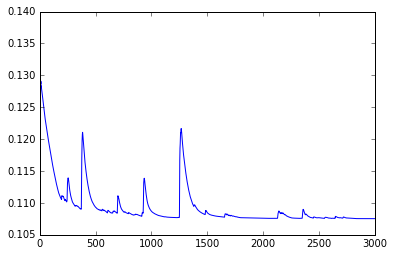

In [49]:
plt.plot(cost_tract)
plt.show()

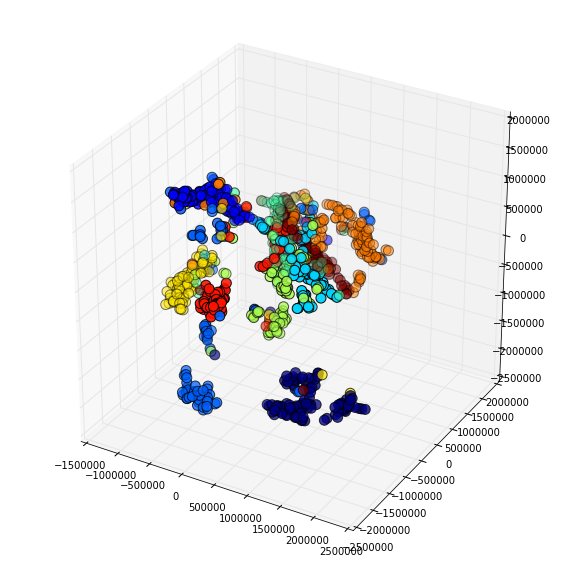

In [62]:
mapped = sess.run(layer4['output'], feed_dict = {x : val['image']})
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
colors = [np.argmax(val['label'][i]) for i in range(ndata)]
ax.scatter(*zip(*mapped), c=colors, s=100)

plt.show()

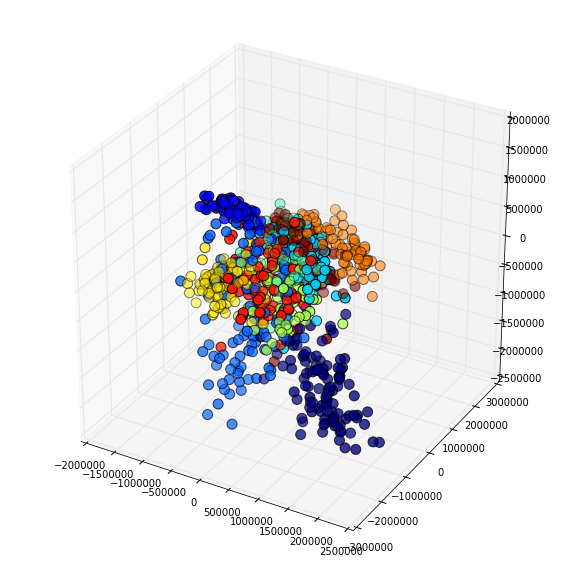

In [66]:
shift = 4000
npoint = 10000
dataset = mnist.train

mapped = sess.run(layer4['output'], feed_dict = {x : dataset.images[shift:shift+ndata]})
mapped = mapped[:npoint]
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
colors = [np.argmax(dataset.labels[shift+i]) for i in range(len(mapped))]
ax.scatter(*zip(*mapped), c=colors, s=100)
plt.show()